In [1]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [2]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data
import torch
import PIL.ImageOps
import skimage

In [3]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [4]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=False)

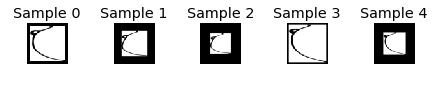

In [5]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [6]:
df = utils.create_df_from_files(path='data/perfiles_CATA/clases/')

#### Build and train classifier

In [7]:
imagenet_data = datasets.ImageFolder('data/perfiles_CATA/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))



In [8]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [9]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

#### Random split

In [10]:
splits_len

(256, 128, 898)

In [11]:
np.sum(splits_len)

1282

In [12]:
#All
splits = utils.random_split(imagenet_data, (1282, 0))

#Only test data 
splits = utils.random_split(imagenet_data, (1282, 0))

#train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=False)
#val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)


In [13]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [14]:
C =_C(input_h_w=64)
C = C.to(available_device)

In [15]:
checkpoint = torch.load("models/checkpoints_data/cnn_vessels_model_500.pth")
C.load_state_dict(checkpoint)

In [16]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

def iterations_test_partial(C, test_loader):
    y_real = list()
    y_pred = list()
    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C.forward_partial(val_input)
        y_pred_batch = score.detach().cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [17]:
y_real, y_pred = iterations_test(C, test_loader)
#print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

/home/pablo/miniconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [18]:
y_real, y_pred = iterations_test_partial(C, test_loader)

In [19]:
colors = plt.cm.afmhot(np.linspace(0, 1, len(y_pred)) * (np.array(y_real)+1)/11)

In [20]:
import pandas as pd
from time import time
from sklearn import manifold
from sklearn.cluster import MiniBatchKMeans

In [21]:
plt.rcParams['figure.figsize'] = [6.0 * 1.5 , 4.0 * 1.5]
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
X_tsne = tsne.fit_transform(y_pred)
#lbls = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit_predict(X_tsne)
ms = MiniBatchKMeans()
lbls = ms.fit_predict(X_tsne)
N_CLUSTERS = np.shape(np.unique(lbls))[0]

In [22]:
files = np.array(imagenet_data.imgs)[test_loader.dataset.indices][:, 0]

In [23]:
merged = pd.DataFrame(np.concatenate(( np.expand_dims(files, 1), np.expand_dims(lbls, 1)), axis=1))

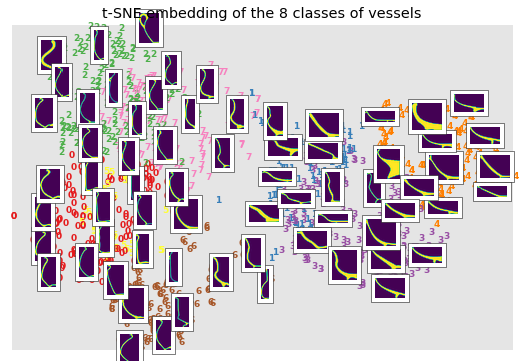

In [24]:
utils.plot_embedding(X_tsne[:,[0,1]], merged, "t-SNE embedding of the {} classes of vessels".format(N_CLUSTERS), N_CLUSTERS)
plt.grid()
plt.show()

In [25]:
clusters = {i:[] for i in np.unique(lbls)} 
for img, j in zip(files, lbls):
    clusters[j].append(img)
size_clusters = [len(i) for i in clusters.values()]

In [26]:
size_clusters

[176, 162, 192, 206, 173, 88, 145, 140]

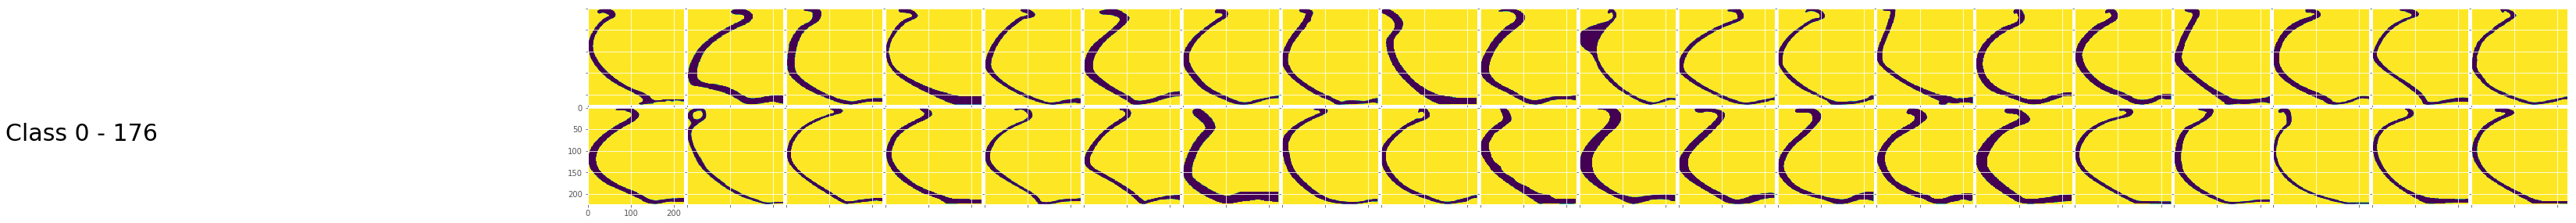

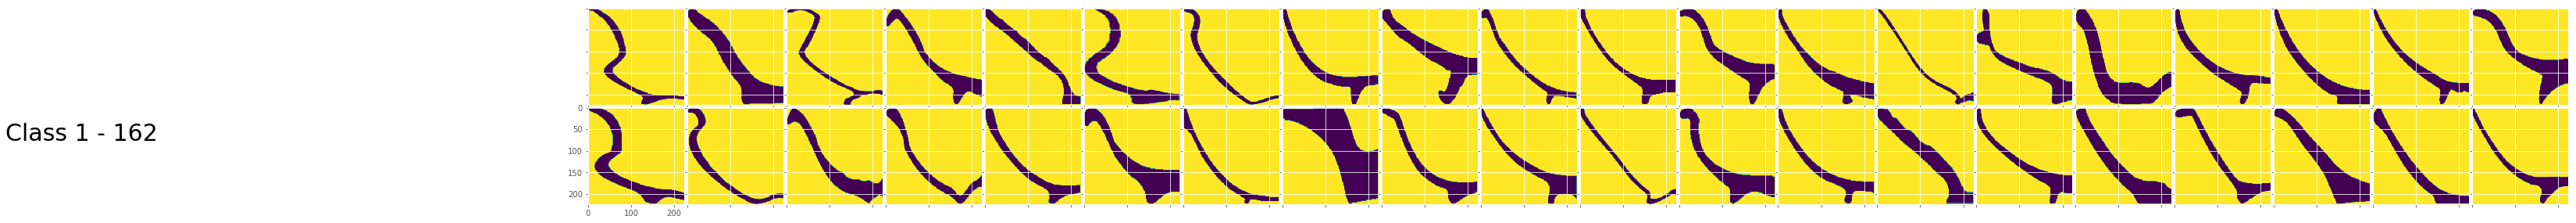

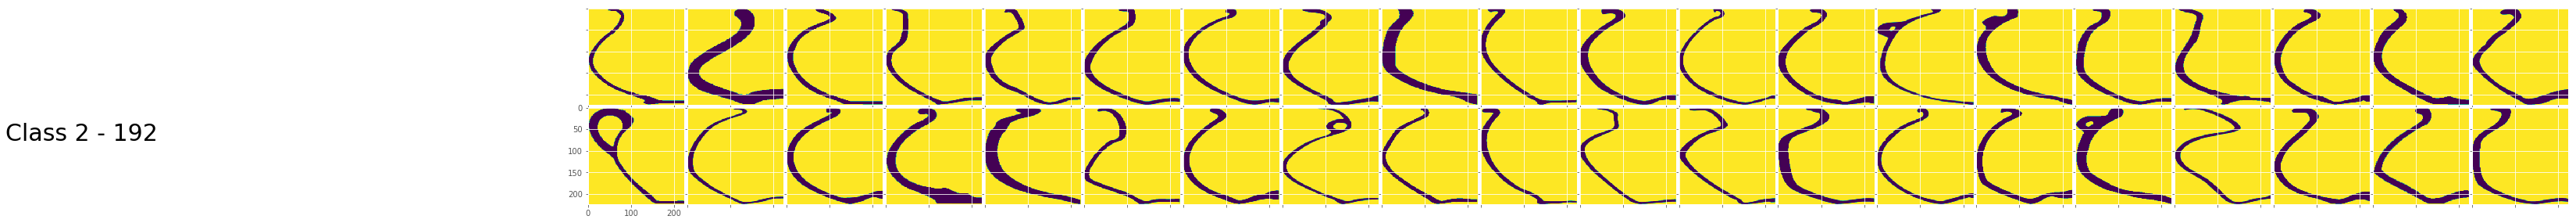

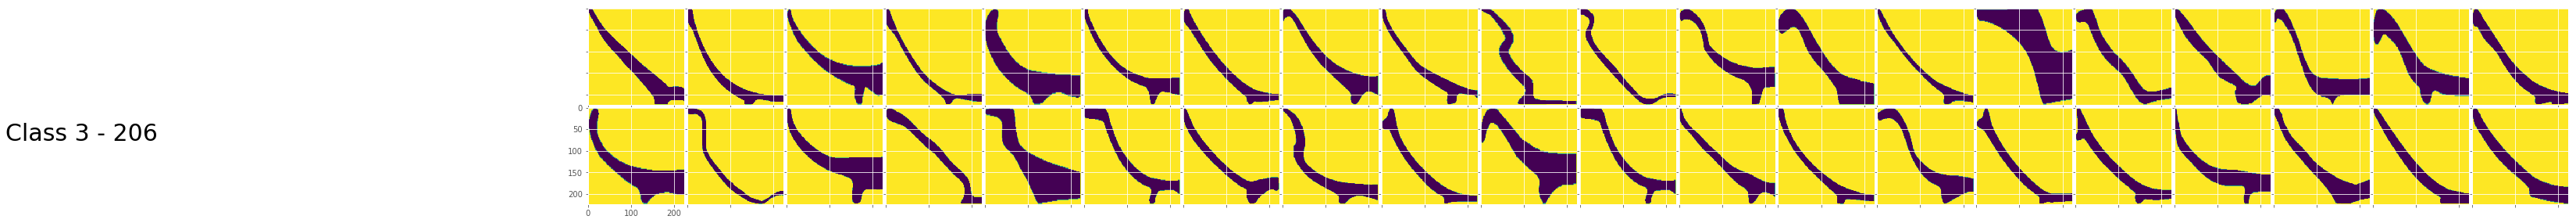

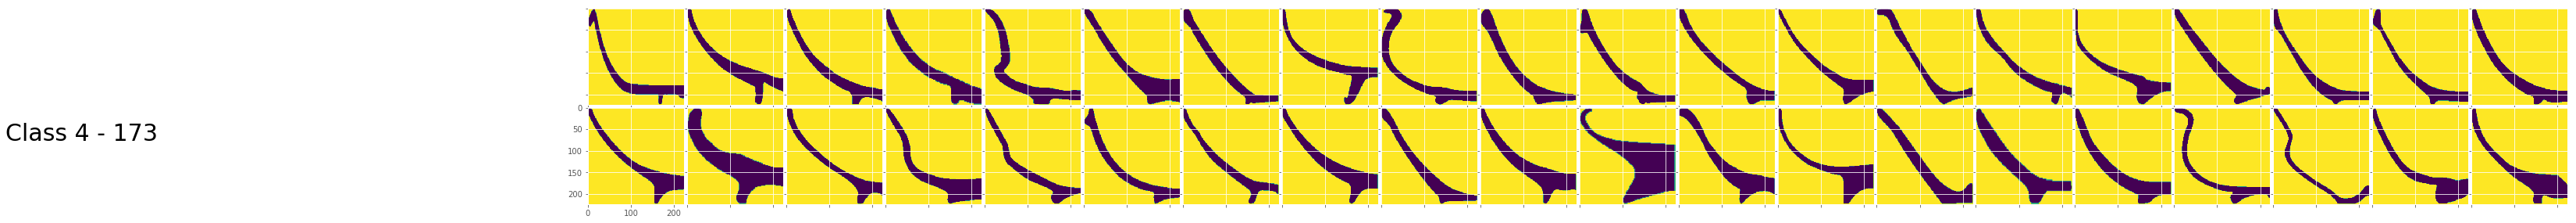

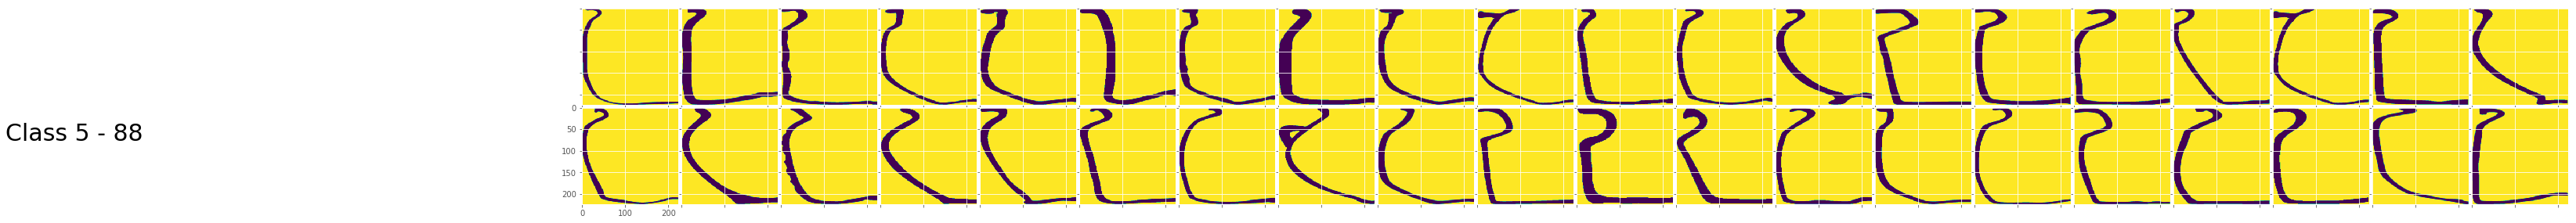

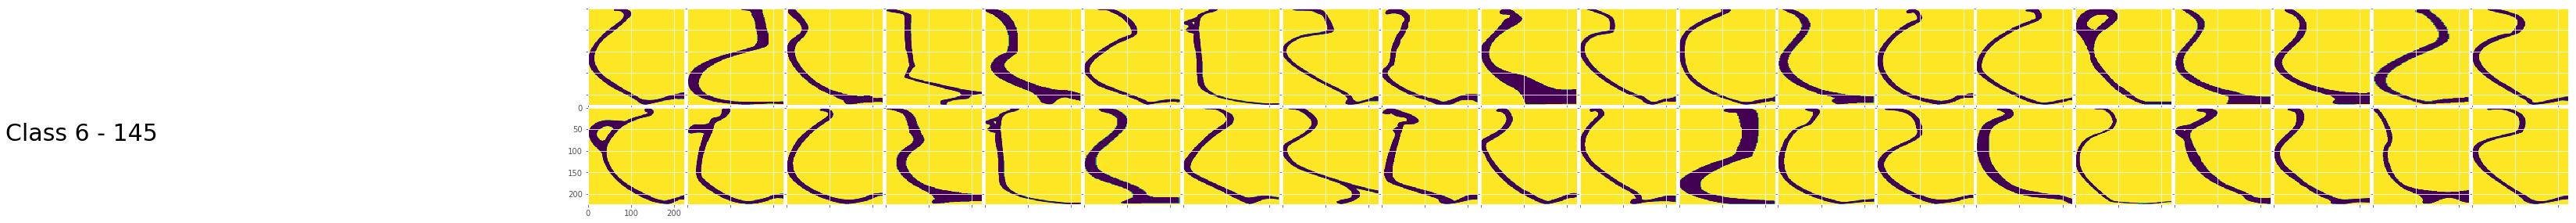

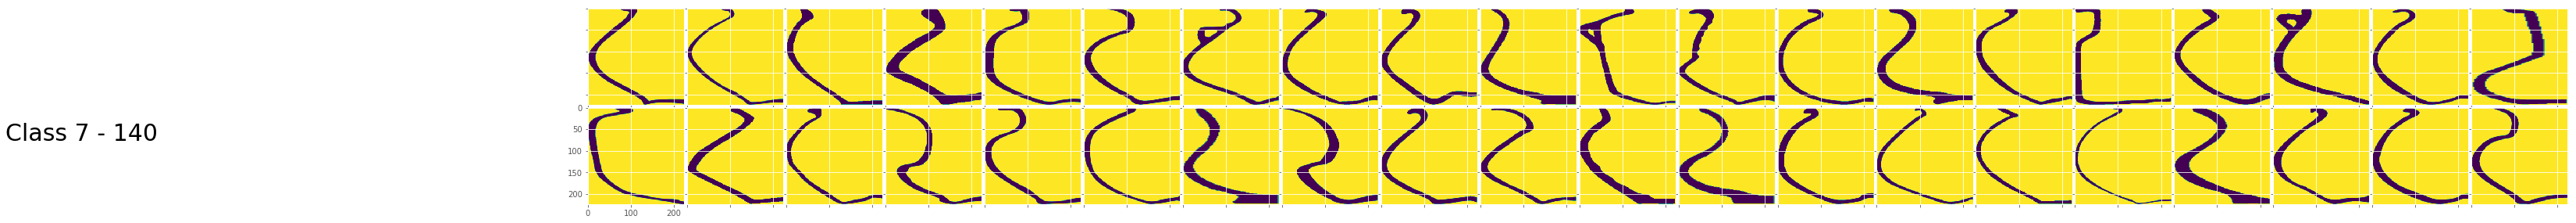

In [27]:
plt.rcParams['figure.figsize'] = [6.0 * 30, 4.0 * 30]
from mpl_toolkits.axes_grid1 import AxesGrid
for idx, c in enumerate(clusters.values()):
    if len(c) < 15:
        continue
    fig = plt.figure()
    fig.suptitle('Class {} - {}'.format(idx, len(c)), fontsize=30, x=0, y = 0.5)

    fig.subplots_adjust(left=0.05, right=0.95)
    grid = AxesGrid(fig, 141, 
                    nrows_ncols=(2, 20),
                    axes_pad=0.05,
                    label_mode="1")
    for i, img in enumerate(c):
        if i < 40:
            grid[i].imshow(skimage.transform.resize(skimage.io.imread(img, 1), (224,224)))

In [28]:
from scipy.spatial import distance

In [29]:
centers = ms.cluster_centers_

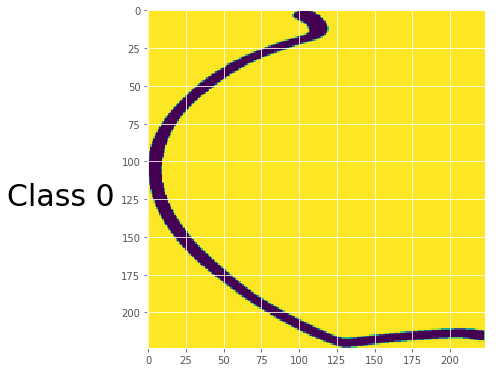

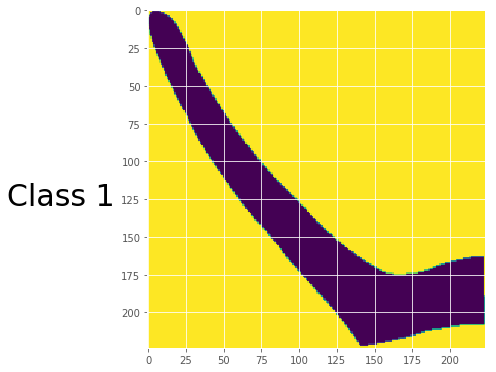

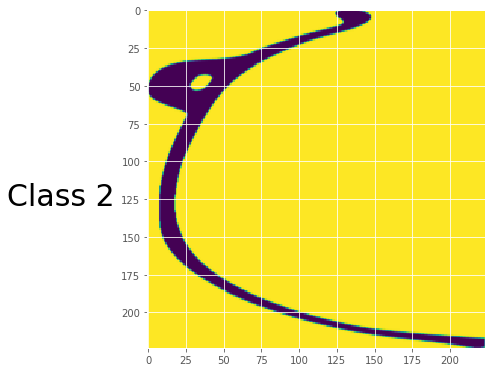

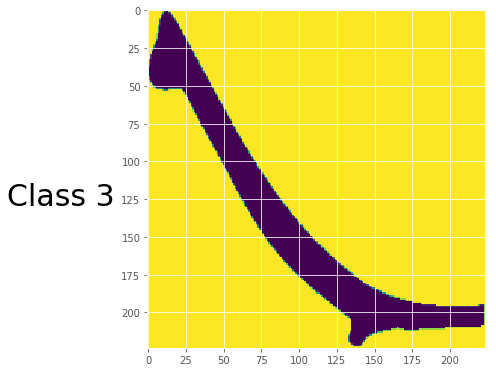

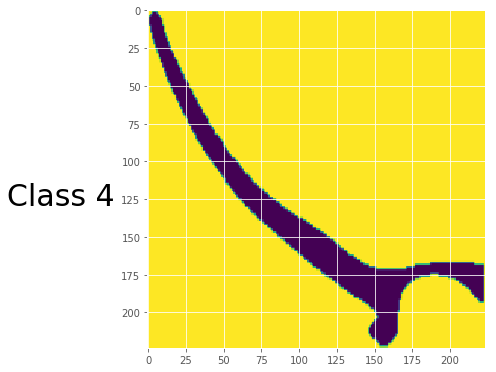

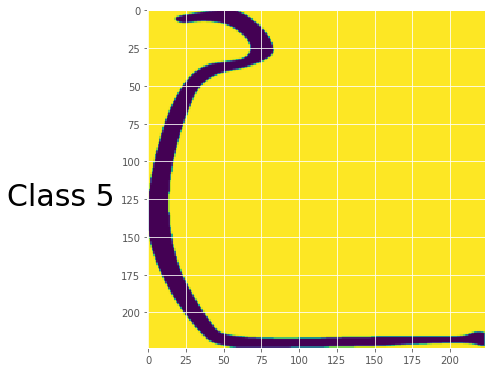

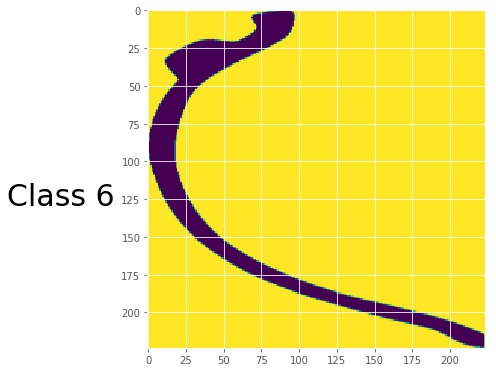

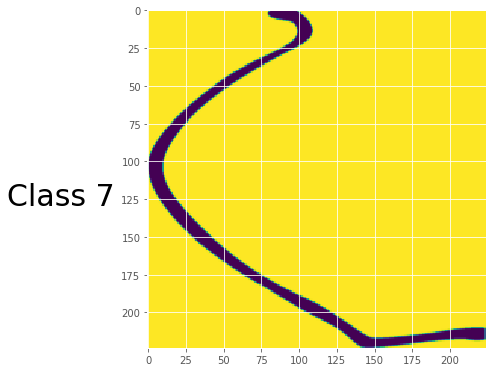

In [30]:
plt.rcParams['figure.figsize'] = [6.0 * 4, 4.0 * 4]
for idx, c in enumerate(clusters.values()):
#for idx, ctr in enumerate(centers):
    if len(c) < 15:
        continue
    ctr = centers[idx]
    img = files[np.argmin(list(map(lambda X: distance.euclidean(X, ctr), X_tsne)))]
    fig = plt.figure()
    fig.suptitle('Class {}'.format(idx), fontsize=30, x=0, y = 0.5)

    fig.subplots_adjust(left=0.05, right=0.95)
    grid = AxesGrid(fig, 141, 
                    nrows_ncols=(1, 1),
                    axes_pad=0.05,
                    label_mode="1")
    grid[0].imshow(skimage.transform.resize(skimage.io.imread(img, 1), (224,224)))